In [1]:
# Check to see if loading function works
import cv2
import mediapipe as mp
import pandas as pd

video_path = "/Users/burrojt1/Desktop/bme_proj/IMG_9092.mov"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    print("Video file loaded successfully!")
    cap.release()


Video file loaded successfully!


In [ ]:
# Function to process video and save keypoints
def process_video(video_path, output_csv):
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # MediaPipe Pose object
    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        frame_data = []
        frame_idx = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_idx += 1

            # Convert BGR image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Detect pose
            results = pose.process(image)

            # Extract pose landmarks
            if results.pose_landmarks:
                frame_landmarks = {
                    "frame": frame_idx,
                    **{f"{landmark.name}_{coord}": coord_value
                       for landmark in mp_pose.PoseLandmark
                       for coord, coord_value in zip(
                           ["x", "y", "z", "visibility"],
                           [
                               results.pose_landmarks.landmark[landmark].x,
                               results.pose_landmarks.landmark[landmark].y,
                               results.pose_landmarks.landmark[landmark].z,
                               results.pose_landmarks.landmark[landmark].visibility,
                           ]
                       )}
                    }
                frame_data.append(frame_landmarks)

            # Optional: Draw pose landmarks on frame for visualization
            annotated_image = frame.copy()
            mp_drawing.draw_landmarks(
                annotated_image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS
            )
            cv2.imshow("Pose Detection", annotated_image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    # Save keypoints to CSV
    keypoints_df = pd.DataFrame(frame_data)
    keypoints_df.to_csv(output_csv, index=False)
    print(f"Saved keypoints to {output_csv}")

In [2]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Load in video and map points
video_path = "/Users/burrojt1/Desktop/bme_proj/IMG_9092.mov"
output_csv = "output_keypoints.csv"
process_video(video_path, output_csv)


I0000 00:00:1733587864.558462 29200300 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733587864.737893 29205581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733587864.764202 29205584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733587864.794148 29205578 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/burrojt1/opt/anaconda3/envs/bme-proj/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype()

Saved keypoints to output_keypoints.csv


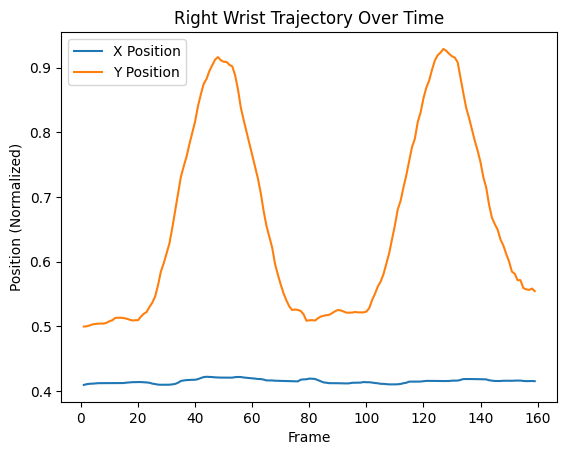

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load keypoints data
data = pd.read_csv("/Users/burrojt1/Desktop/output_keypoints.csv")

# Extract trajectories for a specific joint (e.g., right wrist)
frames = data["frame"]
wrist_x = data["RIGHT_WRIST_x"]
wrist_y = data["RIGHT_WRIST_y"]

# Plot the trajectory
plt.plot(frames, wrist_x, label="X Position")
plt.plot(frames, wrist_y, label="Y Position")
plt.title("Right Wrist Trajectory Over Time")
plt.xlabel("Frame")
plt.ylabel("Position (Normalized)")
plt.legend()
plt.show()


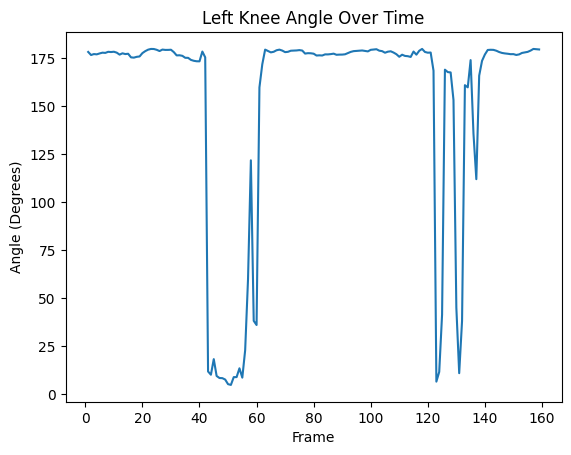

In [4]:
import numpy as np

# Function to calculate angle between three points
def calculate_angle(a, b, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Calculate knee angle (hip, knee, ankle)
data["knee_angle"] = data.apply(
    lambda row: calculate_angle(
        np.array([row["LEFT_HIP_x"], row["LEFT_HIP_y"]]),
        np.array([row["LEFT_KNEE_x"], row["LEFT_KNEE_y"]]),
        np.array([row["LEFT_ANKLE_x"], row["LEFT_ANKLE_y"]]),
    ),
    axis=1,
)

# Plot knee angle over time
plt.plot(data["frame"], data["knee_angle"])
plt.title("Left Knee Angle Over Time")
plt.xlabel("Frame")
plt.ylabel("Angle (Degrees)")
plt.show()


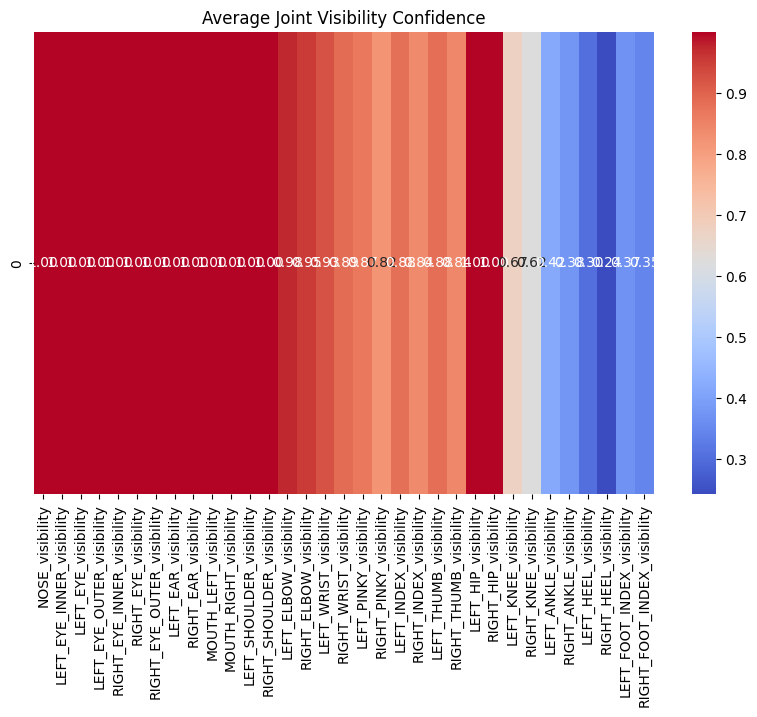

In [9]:
import seaborn as sns

# Extract visibility columns
visibility_cols = [col for col in data.columns if "visibility" in col]
visibility_data = data[visibility_cols].mean(axis=0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap([visibility_data.values], annot=True, fmt=".2f", xticklabels=visibility_cols, cmap="coolwarm")
plt.title("Average Joint Visibility Confidence")
plt.show()

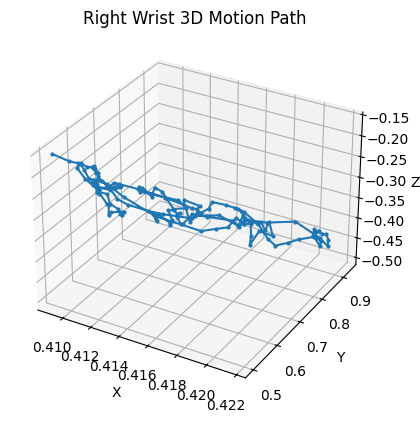

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Extract 3D coordinates for the right wrist
x = data["RIGHT_WRIST_x"]
y = data["RIGHT_WRIST_y"]
z = data["RIGHT_WRIST_z"]

# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, marker="o", markersize=2)
ax.set_title("Right Wrist 3D Motion Path")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()